In [82]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model


In [106]:
# load the data
data = pd.read_csv('complete_data.csv')
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,category
0,1.0,True,"03 25, 2017",A2K5ZBX75J80TX,B009MA34NY,"{'Size:': ' 9 W US', 'Color:': ' Cool Grey / V...",Marjorie A. Dunbar,Ordered 9(m) received 9 Wide for the second ti...,One Star,1490400000,NaN,NaN,amazon_fashion
1,1.0,True,"09 11, 2016",A3SM5XENOINDNH,B010RRWKT4,"{'Size:': ' 7.5 B(M) US', 'Color:': ' Black/Wh...",Marielys Rodrguez,After using this shoes seven times for regular...,Poor Quality. Don't buy.,1473552000,14.0,['https://images-na.ssl-images-amazon.com/imag...,amazon_fashion
2,1.0,True,"05 21, 2015",A36GNVEQP92OPA,B0017LGD34,NaN,Peter B. Thorp,I'm not sure I was shipped the correct style. ...,Huh,1432166400,NaN,NaN,amazon_fashion
3,1.0,True,"02 21, 2017",ABX2R8Q6GBTJ8,B000YFSR5G,"{'Size:': ' Medium', 'Color:': ' Black'}",Sammy C.,Nice pants but too small for a medium. Return it.,Returned also,1487635200,NaN,NaN,amazon_fashion
4,1.0,True,"12 15, 2016",A3PTZ7IHGU9BA8,B009MA34NY,"{'Size:': ' 7 B(M) US', 'Color:': ' Black/Red ...",Amazon Customer,wrong shoes,One Star,1481760000,NaN,NaN,amazon_fashion


In [107]:
# check the shape of the data
data['reviewText'] = data['reviewText'].fillna('No review').astype(str)
data['reviewText'] = data['reviewText'].fillna('').astype(str)
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

# check the shape of the train and test data
print('shape of training set: ', train_data.shape)
print('shape of test set: ', val_data.shape)


# check the distribution of the train and test data
print('training dist', train_data['overall'].value_counts(normalize=True))
print('testing dist', val_data['overall'].value_counts(normalize=True))

shape of training set:  (5151, 13)
shape of test set:  (573, 13)
training dist overall
3.0    0.252378
1.0    0.251796
2.0    0.249466
4.0    0.246360
Name: proportion, dtype: float64
testing dist overall
4.0    0.282723
2.0    0.254799
1.0    0.233857
3.0    0.228621
Name: proportion, dtype: float64


In [108]:
# print the first review and its rating using iloc
print(f"First review: {train_data['reviewText'].iloc[0]}")
print(f"First rating: {train_data['overall'].iloc[0]}")

# print the length of the first review
print(f"Length of first review: {len(train_data['reviewText'].iloc[0])}")

# print the average, max, and min length of the reviews
review_lengths = [len(t) for t in train_data['reviewText']]
print(f"Average length of text: {np.mean(review_lengths)}")
print(f"Max length of text: {np.max(review_lengths)}")
print(f"Min length of text: {np.min(review_lengths)}")

First review: Great product - my wife loves it
First rating: 4.0
Length of first review: 32
Average length of text: 189.71927781013395
Max length of text: 2654
Min length of text: 1


In [39]:
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords

# # Ensure you have the necessary NLTK resources downloaded
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def clean_text(text):
#     # Initialize the lemmatizer and stop words
#     lemmatizer = WordNetLemmatizer()
#     stop_words = set(stopwords.words('english'))

#     # Tokenize and lemmatize
#     tokens = word_tokenize(text.lower())
#     lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]

#     # Remove stop words
#     filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]

#     # Return the cleaned text
#     return ' '.join(filtered_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stinegregersen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stinegregersen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stinegregersen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# train_data['reviewText'] = train_data['reviewText'].apply(clean_text)
# val_data['reviewText'] = val_data['reviewText'].apply(clean_text)

In [109]:
# Create dataframes
df_Xtrain = pd.DataFrame(train_data, columns=['reviewerID','reviewText','summary'])
df_ytrain = pd.DataFrame(train_data, columns=['overall'])
df_Xval = pd.DataFrame(val_data, columns=['reviewerID','reviewText','summary'])
df_yval = pd.DataFrame(val_data, columns=['overall'])
y_train = df_ytrain[['overall']].to_numpy().flatten() - 1
y_val = df_yval[['overall']].to_numpy().flatten() - 1

# Set parameters
max_tokens = 2000 # the maximum number of words to keep, based on word frequency. Only the most common `max_tokens-1` words will be kept.
output_sequence_length = 200 # the maximum length of the sequence to keep. Sequences longer than this will be truncated.
pad_to_max_tokens = True  # Whether to pad to the `output_sequence_length`.

# Ensure the text column is of string type and handle NaN values
train_data['overall'] = train_data['overall'] - 1  # Adjust labels to range 0-3

# Initialize the TextVectorization layer
encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length, pad_to_max_tokens=pad_to_max_tokens)

# Create a dataset of only text data to adapt the encoder
text_ds = tf.data.Dataset.from_tensor_slices(train_data['reviewText']).batch(128)
encoder.adapt(text_ds)

# Get the vocabulary
vocab = np.array(encoder.get_vocabulary())

# Create the full train dataset with text and labels
train_ds = tf.data.Dataset.from_tensor_slices((train_data['reviewText'], train_data['overall'])).batch(128)
train_ds = train_ds.map(lambda x, y: (encoder(x), y))  # Apply TextVectorization to the text data in the dataset

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preparing the validation data
# Convert the texts to sequences using the already adapted TextVectorization layer
text_val_ds = tf.data.Dataset.from_tensor_slices(df_Xval['reviewText']).batch(128)
val_ds = text_val_ds.map(lambda x: encoder(x))

# Configure the dataset for performance
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2024-01-27 12:24:20.346065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5151]
	 [[{{node Placeholder/_0}}]]


In [120]:
embedding_dimension = 128

# Define the model architecture
embedding_model_Bi_reg = Sequential([
    # Embedding layer: converts token indices to dense vectors of fixed size (here, 128 dimensions)
    Embedding(input_dim=len(vocab), output_dim=embedding_dimension, input_length=output_sequence_length, name="embedding"),
    
    # Bidirectional LSTM layer: processes sequences from both directions with 128 units
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    BatchNormalization(),  # Normalizes and stabilizes learning

    # Another Bidirectional LSTM layer: this time with 64 units
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    BatchNormalization(),  # Additional normalization

    # Bidirectional(GRU(32, kernel_regularizer=l2(0.001))),
    # BatchNormalization(),

    # Dense layer with 64 units and ReLU activation function
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout layer for regularization (reduces overfitting)

    # Output layer: Dense layer with softmax activation for multi-class classification
    Dense(4, activation='softmax')
])

# Compile the model
embedding_model_Bi_reg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# TextVectorization layer is used to vectorize text data
X_train_vectorized = encoder(train_data['reviewText'])
X_val_vectorized = encoder(df_Xval['reviewText'])

# Callbacks for model training
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)  # Stops training if validation loss doesn't improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)  # Reduces learning rate if validation loss plateaus

# Training the model with vectorized data
history = embedding_model_Bi_reg.fit(
    X_train_vectorized, y_train, 
    epochs=50, 
    validation_data=(X_val_vectorized, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

2024-01-27 13:24:26.055496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 13:24:26.057832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 13:24:26.059173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-01-27 13:24:27.755930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 13:24:27.758484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 13:24:27.760819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 1.9469 - accuracy: 0.5875

2024-01-27 13:26:06.768499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 13:26:06.771412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 13:26:06.773622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 2.07600, saving model to model.h5
161/161 [==============================] - 105s 567ms/step - loss: 1.9469 - accuracy: 0.5875 - val_loss: 2.0760 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 1.0887 - accuracy: 0.8680
Epoch 2: val_loss improved from 2.07600 to 1.77315, saving model to model.h5
161/161 [==============================] - 89s 551ms/step - loss: 1.0887 - accuracy: 0.8680 - val_loss: 1.7731 - val_accuracy: 0.3630 - lr: 0.0010
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.9165
Epoch 3: val_loss improved from 1.77315 to 1.37027, saving model to model.h5
161/161 [==============================] - 90s 560ms/step - loss: 0.8051 - accuracy: 0.9165 - val_loss: 1.3703 - val_accuracy: 0.5358 - lr: 0.0010
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.9334
Epoch 4: val_loss improved from 1.37027 to

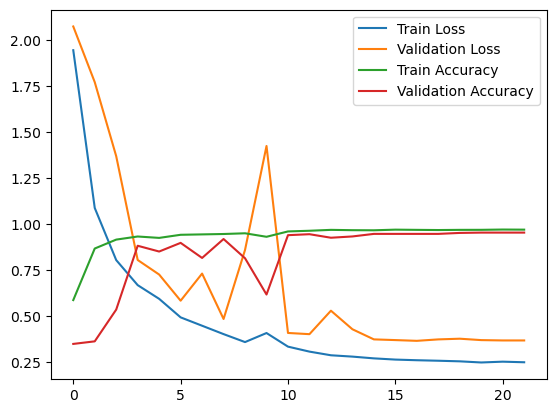

In [121]:
# Plot Loss and accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Loss and Accuracy for RNN')
plt.legend()
# plt.savefig('loss_and_accuracy_for_encoder.png')  # Save the figure before plt.show()
plt.show()
plt.close()

In [122]:
# Load best model
model = load_model('model.h5')

2024-01-27 14:12:19.575770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 14:12:19.577916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 14:12:19.579316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [123]:
# Make predictions
y_pred = model.predict(val_ds)
# The 'predictions' array will contain the probabilities of each class for each sample

# Convert probabilities to class labels
predicted_labels = np.argmax(y_pred, axis=1) + 1

2024-01-27 14:12:24.098048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 14:12:24.100169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 14:12:24.102172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 6s 542ms/step


In [124]:
# Print the classification report
print("Classification Report:\n")
print(classification_report(val_data['overall'], predicted_labels))

# Print the accuracy score
accuracy = accuracy_score(val_data['overall'], predicted_labels)
print("Accuracy Score:", accuracy)

Classification Report:

              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99       134
         2.0       0.97      0.95      0.96       146
         3.0       0.87      0.95      0.91       131
         4.0       0.97      0.90      0.94       162

    accuracy                           0.95       573
   macro avg       0.95      0.95      0.95       573
weighted avg       0.95      0.95      0.95       573

Accuracy Score: 0.9476439790575916


In [125]:
# Load test data
test_data = pd.read_csv('luxury_beauty.csv')

In [126]:
test_data['reviewText'] = test_data['reviewText'].fillna('No review').astype(str)
test_data['reviewText'] = test_data['reviewText'].fillna('').astype(str)

In [49]:
# test_data['reviewText'] = test_data['reviewText'].apply(clean_text)

In [127]:
# Create dataframes
df_Xtest = pd.DataFrame(test_data, columns=['reviewerID','reviewText','summary'])
df_ytest = pd.DataFrame(test_data, columns=['overall'])
y_test = df_ytest[['overall']].to_numpy().flatten() - 1

# Preparing the test data
# Convert the texts to sequences using the already adapted TextVectorization layer
text_test_ds = tf.data.Dataset.from_tensor_slices(df_Xtest['reviewText']).batch(128)
test_ds = text_test_ds.map(lambda x: encoder(x))

# Configure the dataset for performance
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [128]:
# Make predictions
y_pred = model.predict(test_ds)
# The 'predictions' array will contain the probabilities of each class for each sample

# Convert probabilities to class labels
predicted_labels = np.argmax(y_pred, axis=1) + 1

2024-01-27 14:12:40.679513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype string
	 [[{{node Placeholder/_7}}]]


139/139 [==============================] - 74s 534ms/step


In [129]:
# Print the classification report
print("Classification Report:\n")
print(classification_report(test_data['overall'], predicted_labels))

# Print the accuracy score
accuracy = accuracy_score(test_data['overall'], predicted_labels)
print("Accuracy Score:", accuracy)

Classification Report:

              precision    recall  f1-score   support

         1.0       0.22      0.21      0.21      1327
         2.0       0.18      0.09      0.12      1439
         3.0       0.20      0.21      0.20      2412
         4.0       0.78      0.82      0.80     12572

    accuracy                           0.63     17750
   macro avg       0.34      0.33      0.33     17750
weighted avg       0.61      0.63      0.62     17750

Accuracy Score: 0.6305352112676056
